In [64]:
import os
import pandas as pd
import pandas_gbq
import pytz
import io
import numpy as np
import seaborn as sns
from dbfread import DBF
import plotly as py
import plotly.graph_objects as go
import plotly.express as px 
import ipywidgets as widgets

In [63]:
#google cloud big query libraries
from google.cloud import bigquery
from google.oauth2 import service_account

key_path = r"C:\Users\cday\tdm-scenarios-c90ba30c3c5d.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)
 
client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

### Read in Scenarios and Segment Summary Outputs

In [6]:
ScenarioTableID = 'tdm-scenarios.tdm_scenarios_output.scenarios'
scenarios = client.query("SELECT * FROM " + ScenarioTableID).to_dataframe()

SegmentTableID = 'tdm-scenarios.tdm_scenarios_output.segment_summary'
segment_summary = client.query("SELECT * FROM " + SegmentTableID).to_dataframe()

dfSegSum = pd.merge(segment_summary, scenarios, left_on = 'scenarioID', right_on = 'scenarioID', how = 'left')
dfSegSum = dfSegSum.sort_values('scenarioID')

### Create Graphics to show changes between 2 scenarios

In [ ]:
scenario1 = 4
scenario2 = 15

In [47]:
dfMean = dfSegSum.groupby('scenarioID').mean()

TypeError: ufunc 'log' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

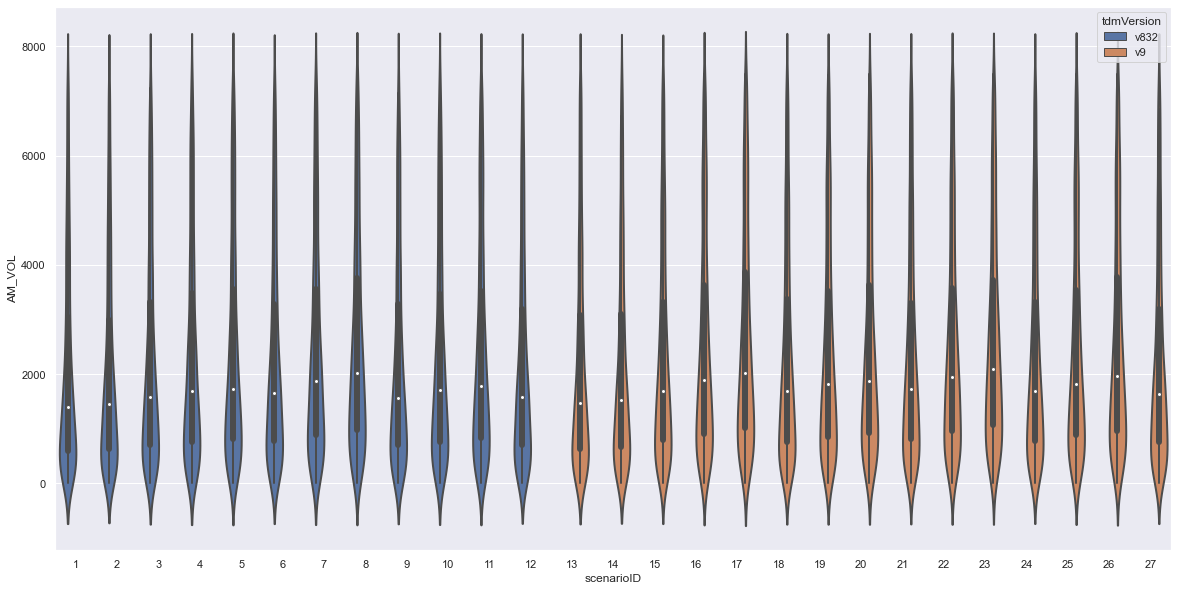

In [60]:
maxValue = 7500
sns.set(rc={'figure.figsize':(20,10)})

vp = sns.violinplot(data=dfSegSum, 
               x="scenarioID", 
               y=dfSegSum[dfSegSum["AM_VOL"]<maxValue]["AM_VOL"],
               hue ="tdmVersion",
               linewidth = 2,
               showfliers = False
              )
#g = sns.FacetGrid(dfSegSum, row="FT")
#g.map(sns.violinplot, 'AM_VOL', 'scenarioID')

In [75]:
##PLOTTING FUNCTION
#
## chart preset zoom extents
#dfZoomPresets = pd.DataFrame([
#    ['Begin' ,     0,   100,     0, np.NaN],
#    ['Mid'   ,    30,   160,     0, 0.0018],
#    ['Tail'  ,   100,   200,     0,0.0001],
#    ['All'   ,np.NaN,200,np.NaN, np.NaN],
#    ['Custom',np.NaN,np.NaN,np.NaN, np.NaN],
#], columns=('PRESET','XMIN','XMAX','YMIN','YMAX'))
#dfZoomPresets

def plot_violin(scenarioOptions, ftOptions):

    data = []
    for scenarios in scenarioOptions:
        for fts in ftOptions:
            # data for plotting from filtered dataframe
            plotdata = dfSegSum[(dfSegSum['scenarioID']==scenarios) & (dfSegSum['FT']==fts)]
            #plotdata = plotdata1[(plotdata1['FF_CALIB_ROUND']==modelspace)]

            # fill any NaN values with zeros
            plotdata = plotdata.fillna(0)

            xplot = plotdata['scenarioID']
            yplot = plotdata['AM_VOL']
            #name  = trippurp + ' ' + tlftype + ' (' + modelspace + ')'

            trace1 =  go.Violin(y = plotdata['AM_VOL'])
            data.append(trace1)
                
    #layout = go.Layout(
    #    title='Trip Length Frequencies - Observed Data',
    #    yaxis=dict(
    #        title='',
    #        range=(_ymin,_ymax)
    #    ),
    #    xaxis=dict(
    #        title='GC/Dist/Time',
    #        range=(_xmin,_xmax)
    #    ),
    #    #width=1600,
    #    height=450
    #)
    
    fig = go.Figure(data=data)#, layout=layout)
    py.offline.iplot(data)

In [76]:
# MAKE INTERACTIVE CHART
py.offline.init_notebook_mode(connected=True)

lstFTType = dfSegSum['FT'].unique().tolist()
lstScenario = list(set(dfSegSum.scenarioID.tolist()))
    
selectFTType       = widgets.SelectMultiple(options=lstFTType    , value=(3,)    , description='Functional Classification')
selectScenario     = widgets.SelectMultiple(options=lstScenario  , value=(1 ,)   , description='Scenario'                 )

widgets.interactive(plot_violin, scenarioOptions = selectScenario, ftOptions = selectFTType)

#ADD RAW OBSERVED CURVES

interactive(children=(SelectMultiple(description='Scenario', index=(0,), options=(1, 2, 3, 4, 5, 6, 7, 8, 9, 1…